In [1]:
""" subsample_list = [1, 57, 235, 13, 121, 223, 220]
country_list = [x for x in country_list if x in subsample_list] """

' subsample_list = [1, 57, 235, 13, 121, 223, 220]\ncountry_list = [x for x in country_list if x in subsample_list] '

### set seed so that the model outputs are reproducible
After the kernel is restarted the same results are created.

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras import initializers
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(0)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

## Load the data

In [3]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from scipy.stats import nbinom, poisson
from time import sleep
from tqdm import tqdm
import warnings


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])

### Drop features that contain missing values

In [4]:
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


data = features_df_list[-1]['data']
if 'gleditsch_ward' in data.columns:
    data = data.drop(columns='gleditsch_ward') # column not necessary

## Features without missing values
columns_without_missing_values = data.columns[data.notna().all()]

for i in range(len(features_df_list)):
    data_set = features_df_list[i]['data']
    features_df_list[i]['data'] = data_set[columns_without_missing_values]

all_features = features_df_list[-1]['data'].columns

### Group data by country_id

In [158]:
country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

## Länder aussortieren
die nicht gefordert sind und
*  die keine actuals haben
*  die zu wenig Beobachtungen haben

In [6]:
relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV-Datei einlesen und als Pandas-Datensatz speichern
countryList_prediction = pd.read_csv(path_countrylist)
country_list_views = countryList_prediction.loc[:,'country_id'].values.tolist() 

month_list = []
countries_to_remove = []
for country_id in country_list:

    if country_id in country_list_views:
        feature_data = country_feature_group_list[0].get_group(country_id)

        # numbers of months from the feature dataset
        month_list_feature_data_original = feature_data.index.get_level_values('month_id').tolist()
        number_months_feature_data = len(month_list_feature_data_original) 

        if check_Actuals(country_id, 0):
            if not check_last_featureMonth(country_id, 0): 
                month_list.append([str(country_id) +' last month missing'])
            else:
                month_list.append([number_months_feature_data, country_id])
        else:
            month_list.append(str(country_id) + ' no actuals')
    else:
        countries_to_remove.append(country_id)

country_list = list(set(country_list) - set(countries_to_remove))
month_list.sort()

## Feed Forward Neural Network
Goal is to estimate the empirical distribution of the fatalities per month.
### Definition of the CRPS loss function and the Feed forward Neural Network subclass

In [7]:
# functions to set the number and partition of the neurons
def number_neurons_allLayers(inputNeurons, outputNeurons):
    return np.round(np.mean([inputNeurons, outputNeurons]))

def split_neurons_3hiddenlayer(numberNeurons):

    neuronsHiddenLayer1 = np.round(numberNeurons * 0.5) 
    neuronsHiddenLayer2 = np.round(numberNeurons * 0.3)
    neuronsHiddenLayer3 = numberNeurons - neuronsHiddenLayer1 - neuronsHiddenLayer2

    return int(neuronsHiddenLayer1), int(neuronsHiddenLayer2), int(neuronsHiddenLayer3)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Input, Dense, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

# crps loss function 
def crps(y_true, S):
    """
    Computes continuous ranked probability score:

    Parameters
    ----------
    y_true : tf tensor of shape (BATCH_SIZE, 1)
        True values.
    S : tf tensor of shape (BATCH_SIZE, N_SAMPLES)
        Predictive samples.

    Returns
    -------
    tf tensor of shape (BATCH_SIZE,)
        Scores.

    """
    beta=1
    n_samples = S.shape[-1]

    def expected_dist(diff, beta):
        return K.sum(K.pow(K.sqrt(K.square(diff)+K.epsilon()), beta),axis=-1) #axis = -1: last dimension <=> N_SAMPLES
    es_1 = expected_dist(y_true - S, beta)
    es_2 = 0
    for i in range(n_samples):
        es_2 = es_2 + expected_dist(K.expand_dims(S[:,i]) - S, beta)
    return es_1/n_samples - es_2/(2*n_samples**2)


class CRPSLoss(Loss):
    def call(self, y_true, S):
        return crps(y_true, S)

# Define custom ReLU activation function
class ReLUTransform(Layer):
    def call(self, inputs):
        return tf.nn.relu(inputs)

# Define the Feed Forward Neural Network subclass
class FeedForwardNN(tf.keras.Model):
    def __init__(self, input_shape, name="FeedFwdNN"):
        super(FeedForwardNN, self).__init__(name=name)
        
        neurons_input = input_shape[-1]
        neurons_output = 200
        neurons_hidden_layer = number_neurons_allLayers(neurons_input,neurons_output)
        neuronsL1, neuronsL2, neuronsL3 = split_neurons_3hiddenlayer(neurons_hidden_layer)


        self.hidden_layer1 = Dense(np.round(neurons_hidden_layer/4), activation='relu')
        self.dropout = Dropout(0.3)
        self.hidden_layer2 = Dense(np.round(neurons_hidden_layer/4), activation='relu')
        self.hidden_layer3 = Dense(np.round(neurons_hidden_layer/4), activation='relu')
        self.hidden_layer4 = Dense(np.round(neurons_hidden_layer/4), activation='relu')
        self.untransformed_output = Dense(neurons_output)
        self.final_output = Lambda(ReLUTransform())

        self.model = self.build(input_shape)
        
    def call(self, inputs):
        x = self.hidden_layer1(inputs)
        #x = self.dropout(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.hidden_layer4(x)
        x = self.untransformed_output(x)
        y = self.final_output(x)
        return y

# Definiere den EarlyStopping-Callback
patience = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


### Data preparation for the Neural Net

In [9]:
import math
from sklearn import preprocessing
## function used to calculate w_max, number of rolling windows etc.
# length of a whole window (containing w input months and 12 acutal months)
def rollingWindowLength(w):
    return w + 2 + 12

def number_valid_months(numberMonths_available, w, relative_validation_size):

    number_train_valid_months = numberMonths_available - w
    number_valid_months = math.floor(number_train_valid_months * relative_validation_size)

    return number_valid_months

# number of months available for training (after removing the validation and test months)
def number_train_months(numberMonths_available, w, relative_validation_size):

    valid_months = number_valid_months(numberMonths_available, w, relative_validation_size)

    #  all months feature data   -  validate set    -   test set input
    return numberMonths_available - valid_months - w


def number_rolling_windows(numberMonths_available, w):
    return max(0,numberMonths_available - rollingWindowLength(w) + 1)



def find_max_W(numberMonths_available, w_min, w_max, relative_validation_size):

    # with "w_min" and the "relative_validation_size" there has to be at least one validation window
    number_valid_months_wmin = number_valid_months(numberMonths_available, w_min, relative_validation_size)

    if number_rolling_windows(number_valid_months_wmin, w_min) == 0:
        raise ValueError('not enough months for one validation window with w_min = ' + str(w_min))

    # with "w_min" and the "relative_validation_size" there has to be at least one train window
    number_train_months_wmin = number_train_months(numberMonths_available, w_min, relative_validation_size)

    if number_rolling_windows(number_train_months_wmin, w_min) == 0:
        raise ValueError('not enough months for one training window with w_min = ' + str(w_min))

    # find the maximal w
    max_W = w_max
    number_valid_months_wmax = number_valid_months(numberMonths_available, max_W, relative_validation_size)
    number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months_wmax, max_W)

    number_train_months_wmax = number_train_months(numberMonths_available, max_W, relative_validation_size)
    number_train_rollwindows_wmax = number_rolling_windows(number_train_months_wmax, max_W)

    # calculate w_max so that the number of rolling windows for the validation set is >= 1
    # and that
    # the number of rolling windows for the train set is >= 1
    while (number_valid_rollwindows_wmax == 0 or number_train_rollwindows_wmax == 0) and max_W > w_min:
        max_W -= 1
        number_valid_months_wmax = number_valid_months(numberMonths_available, max_W, relative_validation_size)
        number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months_wmax, max_W)

        number_train_months_wmax = number_train_months(numberMonths_available, max_W, relative_validation_size)
        number_train_rollwindows_wmax = number_rolling_windows(number_train_months_wmax, max_W)

    return max_W

## conflict trap
# drops all months before a starting conflict
# defintion of a beginning conflict: fatalities(monthX) > 0 with mean(fatalities(window_size number months starting with monthX)) > threshold
# (average fatalities per month in the starting half year are greater than the threshold)
# iterates trough the dataset beginning with the first entry
def drop_before_conflict_trap(data, threshold, window_size, minimal_data_size):
    index_ged_sb = data.columns.get_loc('ged_sb')

    start_index = 0
    while start_index < len(data.iloc[:,index_ged_sb]) - window_size + 1:
        window = data.iloc[start_index:start_index + window_size, index_ged_sb].to_list()
        
        if window[0] > 0 and sum(window) / window_size >= threshold:
            break
        else:
            start_index += 1


    if len(data) >= minimal_data_size:
        # if there is no conflict trap do nothing
        if start_index == len(data.iloc[:,index_ged_sb]) - window_size + 1:
            return data
        # if the truncation would result in a too small dataset prevent this
        elif len(data.iloc[start_index:, :]) < minimal_data_size:
            return data.iloc[-minimal_data_size:, :]
        # drop every entry before the conflict trap 
        else:
            return data.iloc[start_index:, :]
    else:
        return data
    

def TrainValid_ArrayXY_split(w, month_list, data_feature, s):
    X = []
    Y = []

    train_months = len(month_list)

    number_rolling_windows_train = number_rolling_windows(train_months, w)

    for i in range(0, number_rolling_windows_train):
        starting_month_features = month_list[i]

        index_ending_month_features = i + w - 1
        ending_month_features = month_list[index_ending_month_features]

        starting_month_unrActuals = month_list[index_ending_month_features + 3]
        ending_month_unrActuals = month_list[index_ending_month_features + 14]

        window_features = data_feature.loc[slice(starting_month_features, ending_month_features), :] # excluding "unreal" actuals
        window_actuals = data_feature.loc[slice(starting_month_unrActuals, ending_month_unrActuals), 'ged_sb'].iloc[s - 3] # "unreal" actuals


        normalized_window_features = preprocessing.normalize(window_features)
        window_features_array = np.array([normalized_window_features.flatten()])[0]

        window_actual_array = np.array([window_actuals])

        X.append(window_features_array)
        Y.append(window_actual_array)

    X = np.array(X)
    Y = np.array(Y)

    return X,Y

def Test_ArrayXY_split(month_list, data_feature, data_actual, s):
    X = []
    Y = []

    starting_month_test = month_list[0]
    ending_month_test = month_list[-1]

    window_features_test = data_feature.loc[slice(starting_month_test, ending_month_test), :] # all w features to predict the fatalities
    window_actuals_test = data_actual.iloc[s - 3].values # real actuals

    normalized_window_features_test = preprocessing.normalize(window_features_test)
    window_features_array_test = np.array([normalized_window_features_test.flatten()])[0]

    window_actual_array_test = window_actuals_test

    X.append(window_features_array_test)
    Y.append(window_actual_array_test)

    X = np.array(X)
    Y = np.array(Y)

    return X,Y

In [10]:
def rollingWindowLength(w):
    return w + 2 + 12

### non need of w, due to no test set in the hyperparam validation split
def number_valid_monthsRollWindow(numberMonths_available, relative_validation_size):

    number_valid_months = math.floor(numberMonths_available * relative_validation_size)

    return number_valid_months

# number of months available for training (after removing the validation and test months)
def number_train_monthsRollWindow(numberMonths_available, relative_validation_size):

    valid_months = number_valid_monthsRollWindow(numberMonths_available, relative_validation_size)

    #  all months feature data   -  validate set
    return numberMonths_available - valid_months


def number_rolling_windows(numberMonths_available, w):
    return max(0,numberMonths_available - rollingWindowLength(w) + 1)


# no -w because of no test set
def find_max_WRollWindow(numberMonths_available, w_min, w_max, relative_validation_size):

    # with "w_min" and the "relative_validation_size" there has to be at least one validation window
    number_valid_months = number_valid_monthsRollWindow(numberMonths_available, relative_validation_size)

    if number_rolling_windows(number_valid_months, w_min) == 0:
        raise ValueError('not enough months for one validation window with w_min = ' + str(w_min))

    # with "w_min" and the "relative_validation_size" there has to be at least one train window
    number_train_months = number_train_monthsRollWindow(numberMonths_available, relative_validation_size)

    if number_rolling_windows(number_train_months, w_min) == 0:
        raise ValueError('not enough months for one training window with w_min = ' + str(w_min))

    # find the maximal w
    max_W = w_max
    number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months, max_W)

    number_train_rollwindows_wmax = number_rolling_windows(number_train_months, max_W)

    # calculate w_max so that the number of rolling windows for the validation set is >= 1
    # and that
    # the number of rolling windows for the train set is >= 1
    while (number_valid_rollwindows_wmax == 0 or number_train_rollwindows_wmax == 0) and max_W > w_min:
        max_W -= 1
        number_valid_rollwindows_wmax = number_rolling_windows(number_valid_months, max_W)

        number_train_rollwindows_wmax = number_rolling_windows(number_train_months, max_W)

    return max_W




def month_lists_TrainValidTest_RollWindow(w_min, w_max, rel_validation_size, k, k_max, month_list_feature_data):

    # make sure that the lateron used test dataset is not contained in the train/validation process ?!?
    month_list_feature_data_withoutW = month_list_feature_data[:-w_max]

    starting_month = k - 1
    ending_month = k_max - starting_month - 1

    if ending_month == 0:
        month_list_rollwindow_k = month_list_feature_data_withoutW[starting_month:]
    else: 
        month_list_rollwindow_k = month_list_feature_data_withoutW[starting_month:-ending_month]
    

    # numbers of months from the feature dataset
    first_month = min(month_list_rollwindow_k)
    last_month = max(month_list_rollwindow_k)
    number_months_rollwindow_k = len(month_list_rollwindow_k)
    
    # find w_max (as mentioned above, if there are not enoug months, the w_max has to be < w_max)
    w_max_local = find_max_WRollWindow(number_months_rollwindow_k, w_min, w_max, rel_validation_size)

    w = w_max_local
    print('Wmax = ' + str(w_max) + ' w = ' + str(w))

    # length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
    n_train_months = number_train_monthsRollWindow(number_months_rollwindow_k, rel_validation_size)
    n_valid_months = number_valid_monthsRollWindow(number_months_rollwindow_k, rel_validation_size)

    print('rolling windows train: ' + str(number_rolling_windows(n_train_months, w)))
    print('rolling windows validate: ' + str(number_rolling_windows(n_valid_months, w)))

    month_list_train = month_list_rollwindow_k[0:n_train_months]
    month_list_valid = month_list_rollwindow_k[n_train_months:(n_train_months+n_valid_months)]

    month_list_test = month_list_feature_data[-w:]

    return month_list_train, month_list_valid, month_list_test, w





#--------------------


""" ## training dataset------
X_train, Y_train = TrainValid_ArrayXY_split(n_train_months, w, month_list_train, feature_data, s)

## validation dataset--------
X_validate, Y_validate = TrainValid_ArrayXY_split(n_valid_months, w, month_list_valid, feature_data, s) """





' ## training dataset------\nX_train, Y_train = TrainValid_ArrayXY_split(n_train_months, w, month_list_train, feature_data, s)\n\n## validation dataset--------\nX_validate, Y_validate = TrainValid_ArrayXY_split(n_valid_months, w, month_list_valid, feature_data, s) '

### Feature subsets

In [11]:
## different feature selection from views
# 59 features that map the conflict history of a country
conflict_history = [
    'ged_sb', 'decay_ged_sb_5', 'decay_ged_os_5',
    'splag_1_decay_ged_sb_5', 'wdi_sp_pop_totl', 'ln_ged_sb_tlag_1',
    'ln_ged_sb_tlag_2', 'ln_ged_sb_tlag_3', 'ln_ged_sb_tlag_4',
    'ln_ged_sb_tlag_5', 'ln_ged_sb_tlag_6', 'ln_ged_sb_tsum_24',
    'decay_ged_sb_100', 'decay_ged_sb_500', 'decay_ged_os_100',
    'decay_ged_ns_5', 'decay_ged_ns_100', 'ln_ged_ns', 'ln_ged_os',
    'ln_acled_sb', 'ln_acled_sb_count', 'ln_acled_os',
    'ln_ged_os_tlag_1', 'decay_acled_sb_5', 'decay_acled_os_5',
    'decay_acled_ns_5', 'splag_1_decay_ged_os_5',
    'splag_1_decay_ged_ns_5'
]
# 59 features that are drawn from the Varieties of Democracy project
vdem = [
    'ged_sb', 'decay_ged_sb_5', 'decay_ged_os_5',
    'splag_1_decay_ged_sb_5', 'wdi_sp_pop_totl', 'vdem_v2x_delibdem',
    'vdem_v2x_egaldem', 'vdem_v2x_libdem', 'vdem_v2x_libdem_48',
    'vdem_v2x_partip', 'vdem_v2x_accountability',
    'vdem_v2x_civlib', 'vdem_v2x_clphy', 'vdem_v2x_cspart',
    'vdem_v2x_divparctrl', 'vdem_v2x_edcomp_thick', 'vdem_v2x_egal',
    'vdem_v2x_execorr', 'vdem_v2x_frassoc_thick', 'vdem_v2x_gencs',
    'vdem_v2x_gender', 'vdem_v2x_genpp', 'vdem_v2x_horacc',
    'vdem_v2x_neopat', 'vdem_v2x_pubcorr', 'vdem_v2x_rule',
    'vdem_v2x_veracc', 'vdem_v2x_freexp', 'vdem_v2xcl_acjst', 
    'vdem_v2xcl_dmove', 'vdem_v2xcl_prpty', 'vdem_v2xcl_rol', 
    'vdem_v2xcl_slave', 'vdem_v2xdl_delib', 'vdem_v2xeg_eqdr',
    'vdem_v2xeg_eqprotec', 'vdem_v2xel_frefair', 'vdem_v2xel_regelec',
    'vdem_v2xme_altinf', 'vdem_v2xnp_client', 'vdem_v2xnp_regcorr',
    'vdem_v2xpe_exlecon', 'vdem_v2xpe_exlpol', 'vdem_v2xpe_exlgeo',
    'vdem_v2xpe_exlgender', 'vdem_v2xpe_exlsocgr', 'vdem_v2xps_party',
    'vdem_v2xcs_ccsi', 'vdem_v2xnp_pres', 'vdem_v2xeg_eqaccess',
    'vdem_v2x_diagacc', 'vdem_v2clrgunev', 'splag_vdem_v2x_libdem',
    'splag_vdem_v2xcl_dmove', 'splag_vdem_v2x_accountability',
    'splag_vdem_v2xpe_exlsocgr', 'splag_vdem_v2xcl_rol', 'wdi_sm_pop_netm',
    'wdi_sp_dyn_imrt_in'
]

# 30 features that are drawn from the WDI as well as some conflict history indicators
wdi = [
    'ged_sb', 'decay_ged_sb_5', 'decay_ged_os_5',
    'splag_1_decay_ged_sb_5', 'wdi_sp_pop_totl', 'wdi_ag_lnd_frst_k2',
    'wdi_dt_oda_odat_pc_zs', 'wdi_ms_mil_xpnd_gd_zs', 'wdi_ms_mil_xpnd_zs',
    'wdi_nv_agr_totl_kd', 'wdi_nv_agr_totl_kn', 'wdi_ny_gdp_pcap_kd',
    'wdi_sp_dyn_le00_in', 'wdi_se_prm_nenr', 'wdi_sh_sta_maln_zs', 
    'wdi_sh_sta_stnt_zs', 'wdi_sl_tlf_totl_fe_zs', 'wdi_sm_pop_refg_or', 
    'wdi_sm_pop_netm', 'wdi_sm_pop_totl_zs', 'wdi_sp_dyn_imrt_in', 
    'wdi_sh_dyn_mort_fe', 'wdi_sp_pop_1564_fe_zs', 'wdi_sp_pop_65up_fe_zs',
    'wdi_sp_pop_grow', 'wdi_sp_urb_totl_in_zs',
    'splag_wdi_sl_tlf_totl_fe_zs', 'splag_wdi_sm_pop_refg_or',
    'splag_wdi_sm_pop_netm', 'splag_wdi_ag_lnd_frst_k2'
]

ged = ['ged_sb']

feature_subset_dict = {'conflict_history':conflict_history,
                       'vdem':vdem,
                       'wdi':wdi,
                       'all':all_features,
                       'ged':ged}

In [31]:
### prediction task old
prediction_year = '2021'
dataset_index = actual_years.index(prediction_year)
s = 3 # month to predict element out of [3,14]

### set hyperparameters for the prediction task
## dataset (split) hyperparams
rel_validation_size = 0.4 # percentual size of the validation set
var_threshold = 0.05 # variance threshold for dropping columns
mean_fatlities_per_month_threshold = 5 # threshold for the average number of fatalities per month (conflict trap detection)

w_max = 12 # the maximal w (months to estimate the fatalities from) is set to e.g. 3 years (36 months)
# BUT: If w_max=36 leads to a number of rolling windows < 1 in the validation dataset,
# w_max is set to the maximal w, so that the number of rolling windows is >= 1
# => this step is done below in the section for each country

w_min = 2 # to calculate the w_max the w_min has to be set as well

feature_subset = 'ged' # 'conflict_history', 'vdem', 'wdi', 'all',


## country 223
country = 220 #220  245

# check if the last month of the country in the feature dataset is 3 months before the first month that has to be predicted
if not check_last_featureMonth(country, dataset_index):
    raise ValueError('last month is not contained in the data')

### load and prepare datasets
feature_data = country_feature_group_list[dataset_index].get_group(country)

# only FEATURE SUBSET
feature_data = feature_data.loc[:,feature_subset_dict[feature_subset]]

## Drop features with NEAR ZERO VARIANCE (but dont drop 'ged_sb' -> needed for conflict trap detection)
columns_to_keep = [col for col in feature_data.columns if (col == 'ged_sb') or (feature_data[col].var() >= var_threshold)]
feature_data = feature_data[columns_to_keep]

actual_data = country_actual_group_list[dataset_index].get_group(country)

## remove months before the CONDFLICT TRAP (regime change)
# if the average number of fatalities per month in 6 months is above 'mean_fatlities_per_month_threshold' and the fatalities of the starting month are > 0 
# the conflict trap starts and all obsservations before that month are dropped
# 76 is the minimal length of the dataframe (refers to the minimal size of the data for all countries -> country_id 246 len = 76) 
feature_data = drop_before_conflict_trap(feature_data, mean_fatlities_per_month_threshold, 6, 76)


# numbers of months from the feature dataset
month_list_feature_data = feature_data.index.get_level_values('month_id').tolist()
first_month = min(month_list_feature_data)
last_month = max(month_list_feature_data)
number_months_feature_data = len(month_list_feature_data) # number of months in the feature dataset

# find w_max (as mentioned above, if there are not enoug months, the w_max has to be < 36)
w_max_local = find_max_W(number_months_feature_data, w_min, w_max, rel_validation_size)

w = w_max_local

### split data in train-, validation- and test-dataset
""" The data sizes are calculated in a way, that missing months are no problem. Additionaly due to the fact, that the data is sorted
    regarding months, this step can be skipped. """

## train-valid-test------------------
# length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
n_train_months = number_train_months(number_months_feature_data, w, rel_validation_size)
n_valid_months = number_valid_months(number_months_feature_data, w, rel_validation_size)
n_test_months = w

month_list_train = month_list_feature_data[0:n_train_months]
month_list_valid = month_list_feature_data[n_train_months:(n_train_months+n_valid_months)]
month_list_test = month_list_feature_data[number_months_feature_data-n_test_months:]
#--------------------


## training dataset------
X_train, Y_train = TrainValid_ArrayXY_split(w, month_list_train, feature_data, s)

## validation dataset--------
X_validate, Y_validate = TrainValid_ArrayXY_split(w, month_list_valid, feature_data, s)

## test dataset-------
X_test, Y_test = Test_ArrayXY_split(month_list_test, feature_data, actual_data, s)


print('(first, last) train month: (' + str(month_list_train[0])+','+str(month_list_train[-1])+')')
print('(first, last) validate month: (' + str(month_list_valid[0])+','+str(month_list_valid[-1])+')')
print('(first, last) test month: (' + str(month_list_test[0])+','+str(month_list_test[-1])+')')
print('train + valid + test = ' + str(n_train_months + n_valid_months +n_test_months) + ' != ' + str(number_months_feature_data))


print('')
print('# rolling w train: ' + str(number_rolling_windows(n_train_months, w)) + '      # rolling w validate: ' + str(number_rolling_windows(n_valid_months, w)))
print('w = ' + str(w) + ' w_max = ' + str(w_max))

(first, last) train month: (379,438)
(first, last) validate month: (439,478)
(first, last) test month: (479,490)
train + valid + test = 112 != 112

# rolling w train: 35      # rolling w validate: 15
w = 12 w_max = 12


In [162]:
#[28, 60, 65, 67, 96, 121, 133, 136, 145, 149, 218, 223, 245, 246]

country = 223 #220  245

feature_subset = 'all'

# check if the last month of the country in the feature dataset is 3 months before the first month that has to be predicted
if not check_last_featureMonth(country, dataset_index):
    raise ValueError('last month is not contained in the data')

### load and prepare datasets
feature_data = country_feature_group_list[dataset_index].get_group(country)

# only FEATURE SUBSET
feature_data = feature_data.loc[:,feature_subset_dict[feature_subset]]

## Drop features with NEAR ZERO VARIANCE (but dont drop 'ged_sb' -> needed for conflict trap detection)
columns_to_keep = [col for col in feature_data.columns if (col == 'ged_sb') or (feature_data[col].var() >= var_threshold)]
feature_data = feature_data[columns_to_keep]

actual_data = country_actual_group_list[dataset_index].get_group(country)

## remove months before the CONDFLICT TRAP (regime change)
# if the average number of fatalities per month in 6 months is above 'mean_fatlities_per_month_threshold' and the fatalities of the starting month are > 0 
# the conflict trap starts and all obsservations before that month are dropped
# 76 is the minimal length of the dataframe (refers to the minimal size of the data for all countries -> country_id 246 len = 76) 
feature_data = drop_before_conflict_trap(feature_data, mean_fatlities_per_month_threshold, 6, 76)



month_liste = feature_data.index.get_level_values('month_id').tolist()
w_min = 1
w_max = 6
rel_validation_size = 0.3
k=1
k_max = 1


YYdistribution_list = [{'Y_train':None, 'Y_valid':None } for _ in range(14)]


print('Starting month: ' + str(month_liste[0]))
print('Ending month: ' + str(month_liste[-1]))
print(' ')
print(' ')

for s in range(3,14+1):
    month_list_train, month_list_valid, month_list_test, w = month_lists_TrainValidTest_RollWindow(w_min, w_max, rel_validation_size, k, k_max, month_liste)

    print(' ')
    print('k = ' + str(k))
    

    print(month_list_train)
    print(month_list_valid)
    print(month_list_test)

    ## training dataset------
    X_train, Y_train = TrainValid_ArrayXY_split(w, month_list_train, feature_data, s)
    print('len x train input ' + str(len(X_train[0])))

    ## validation dataset--------
    X_validate, Y_validate = TrainValid_ArrayXY_split(w, month_list_valid, feature_data, s)
    print('len x validate input ' + str(len(X_validate[0])))

    ## test dataset-------
    X_test, Y_test = Test_ArrayXY_split(month_list_test, feature_data, actual_data, s)
    print('len x test input ' + str(len(X_test[0])))
    print(' ')

    print('(first, last) train month: (' + str(month_list_train[0])+','+str(month_list_train[-1])+')')
    print('(first, last) validate month: (' + str(month_list_valid[0])+','+str(month_list_valid[-1])+')')
    print('(first, last) test month: (' + str(month_list_test[0])+','+str(month_list_test[-1])+')')
    print('')

    YYdistribution_list[s-3]['Y_train'] = Y_train
    YYdistribution_list[s-3]['Y_valid'] = Y_validate

    



Starting month: 121
Ending month: 490
 
 
Wmax = 6 w = 6
rolling windows train: 236
rolling windows validate: 90
 
k = 1
[121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296

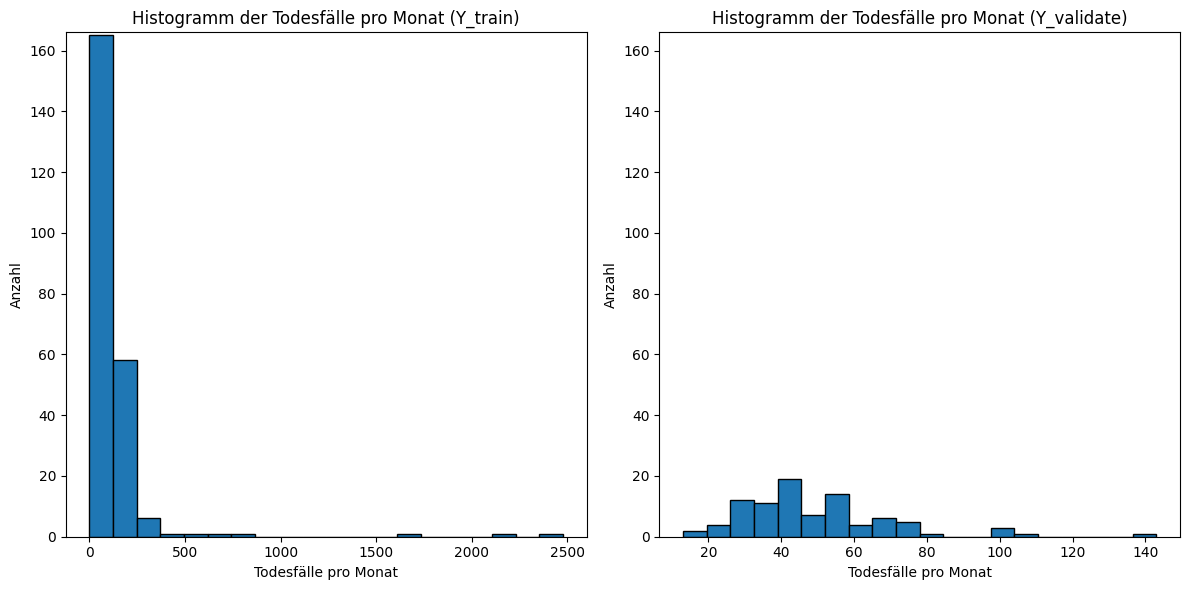

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Daten für das erste Histogramm (Y_train)
data = YYdistribution_list[0]['Y_train']

# Daten für das zweite Histogramm (Y_validate)
data2 = YYdistribution_list[0]['Y_valid']

# Erstellen Sie eine Figur mit zwei Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Histogramm für das erste Dataset (Y_train)
n1, bins1, patches1 = ax1.hist(data, bins=20, edgecolor='black')
ax1.set_xlabel('Todesfälle pro Monat')
ax1.set_ylabel('Anzahl')
ax1.set_title('Histogramm der Todesfälle pro Monat (Y_train)')


# Histogramm für das zweite Dataset (Y_validate)
n2, bins2, patches2 = ax2.hist(data2, bins=20, edgecolor='black')
ax2.set_xlabel('Todesfälle pro Monat')
ax2.set_ylabel('Anzahl')
ax2.set_title('Histogramm der Todesfälle pro Monat (Y_validate)')
ax1.set_ylim(0, max(max(n1), max(n2)) + 1)  # Y-Achse auf das Maximum der maximalen Häufigkeiten einstellen
ax2.set_ylim(0, max(max(n1), max(n2)) + 1)  # Y-Achse auf das Maximum der maximalen Häufigkeiten einstellen

# Abstand zwischen den Subplots einstellen
plt.tight_layout()

# Zeigen Sie die beiden Histogramme an
plt.show()


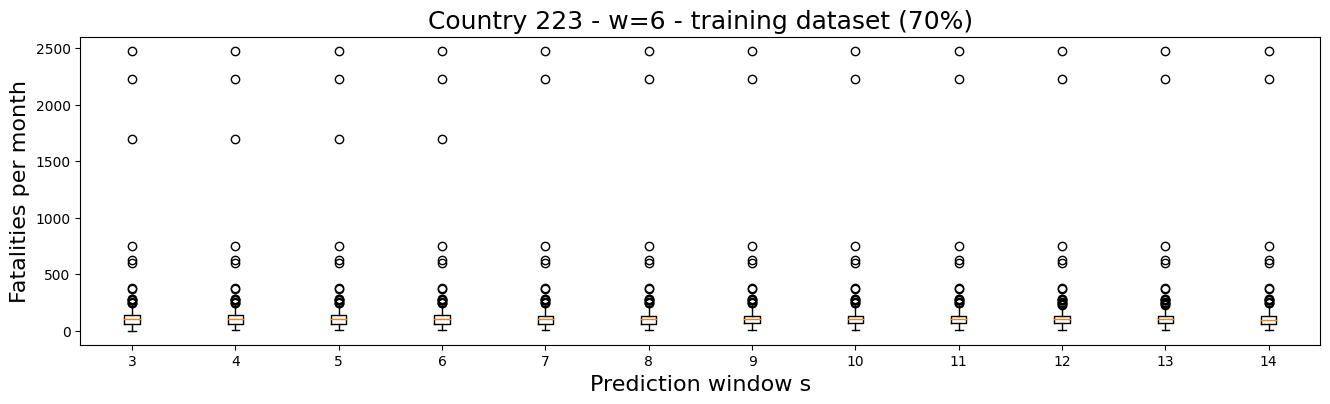

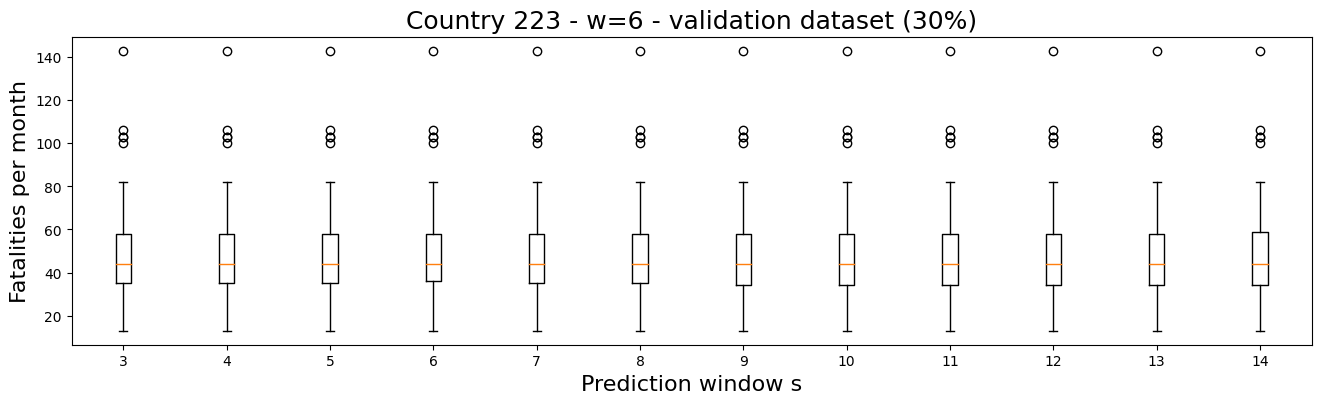

In [164]:
plt.figure(figsize=(16, 4))
for s in range(3,14+1):
    # Erstellen Sie den Boxplot für data
    plt.boxplot(YYdistribution_list[s-3]['Y_train'], positions=[s-3 + 1], labels=[str(s)])

# Optional: Beschriftungen hinzufügen
plt.xlabel('Prediction window s', fontsize=16)
plt.ylabel('Fatalities per month', fontsize=16)
plt.title('Country ' +str(country) + ' - w=' + str(w) + ' - training dataset (70%)', fontsize=18)

# Den Boxplot anzeigen
plt.show()

plt.figure(figsize=(16, 4))
for s in range(3,14+1):
    # Erstellen Sie den Boxplot für data2 neben data
    plt.boxplot(YYdistribution_list[s-3]['Y_valid'], positions=[s - 3 +1], labels=[str(s)])

# Optional: Beschriftungen hinzufügen
plt.xlabel('Prediction window s', fontsize=16)
plt.ylabel('Fatalities per month', fontsize=16)
plt.title('Country ' +str(country) + ' - w=' + str(w) + ' - validation dataset (30%)', fontsize=18)

# Den Boxplot anzeigen
plt.show()

In [165]:

country = 223 #220  245

feature_subset = 'all'

# check if the last month of the country in the feature dataset is 3 months before the first month that has to be predicted
if not check_last_featureMonth(country, dataset_index):
    raise ValueError('last month is not contained in the data')

### load and prepare datasets
feature_data = country_feature_group_list[dataset_index].get_group(country)

# only FEATURE SUBSET
feature_data = feature_data.loc[:,feature_subset_dict[feature_subset]]

## Drop features with NEAR ZERO VARIANCE (but dont drop 'ged_sb' -> needed for conflict trap detection)
columns_to_keep = [col for col in feature_data.columns if (col == 'ged_sb') or (feature_data[col].var() >= var_threshold)]
feature_data = feature_data[columns_to_keep]

actual_data = country_actual_group_list[dataset_index].get_group(country)

## remove months before the CONDFLICT TRAP (regime change)
# if the average number of fatalities per month in 6 months is above 'mean_fatlities_per_month_threshold' and the fatalities of the starting month are > 0 
# the conflict trap starts and all obsservations before that month are dropped
# 76 is the minimal length of the dataframe (refers to the minimal size of the data for all countries -> country_id 246 len = 76) 
feature_data = drop_before_conflict_trap(feature_data, mean_fatlities_per_month_threshold, 6, 76)



month_liste = feature_data.index.get_level_values('month_id').tolist()
w_min = 1
rel_validation_size = 0.3
k=1
k_max = 1

s = 8

YYdistribution_list = [{'Y_train':None, 'Y_valid':None } for _ in range(12)]

for w_max in range(1,12+1):
    month_list_train, month_list_valid, month_list_test, w = month_lists_TrainValidTest_RollWindow(w_min, w_max, rel_validation_size, k, k_max, month_liste)

    ## training dataset------
    X_train, Y_train = TrainValid_ArrayXY_split(w, month_list_train, feature_data, s)

    ## validation dataset--------
    X_validate, Y_validate = TrainValid_ArrayXY_split(w, month_list_valid, feature_data, s)

    ## test dataset-------
    X_test, Y_test = Test_ArrayXY_split(month_list_test, feature_data, actual_data, s)
    print('')

    YYdistribution_list[w_max-1]['Y_train'] = Y_train
    YYdistribution_list[w_max-1]['Y_valid'] = Y_validate

Wmax = 1 w = 1
rolling windows train: 245
rolling windows validate: 96



Wmax = 2 w = 2
rolling windows train: 243
rolling windows validate: 95

Wmax = 3 w = 3
rolling windows train: 241
rolling windows validate: 94

Wmax = 4 w = 4
rolling windows train: 240
rolling windows validate: 92

Wmax = 5 w = 5
rolling windows train: 238
rolling windows validate: 91

Wmax = 6 w = 6
rolling windows train: 236
rolling windows validate: 90

Wmax = 7 w = 7
rolling windows train: 235
rolling windows validate: 88

Wmax = 8 w = 8
rolling windows train: 233
rolling windows validate: 87

Wmax = 9 w = 9
rolling windows train: 231
rolling windows validate: 86

Wmax = 10 w = 10
rolling windows train: 229
rolling windows validate: 85

Wmax = 11 w = 11
rolling windows train: 228
rolling windows validate: 83

Wmax = 12 w = 12
rolling windows train: 226
rolling windows validate: 82



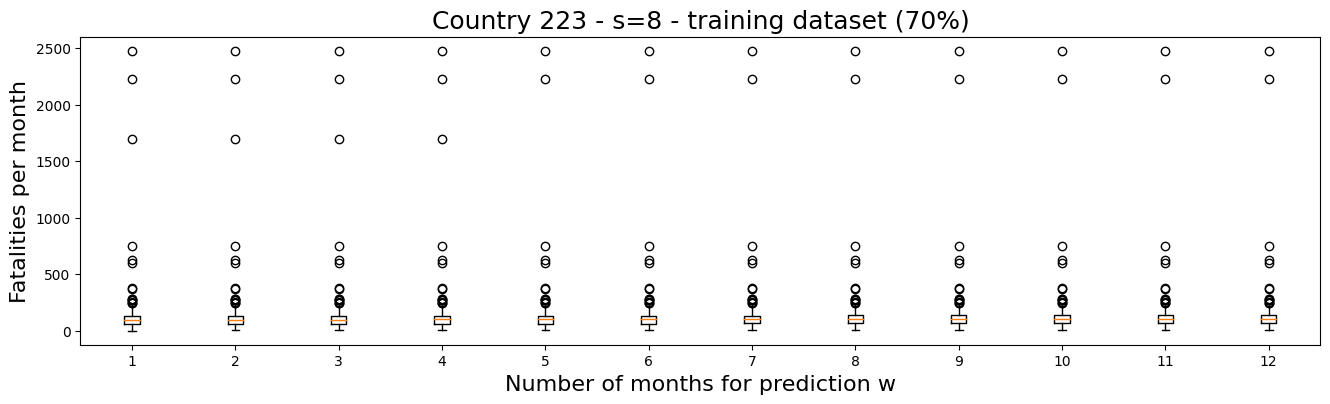

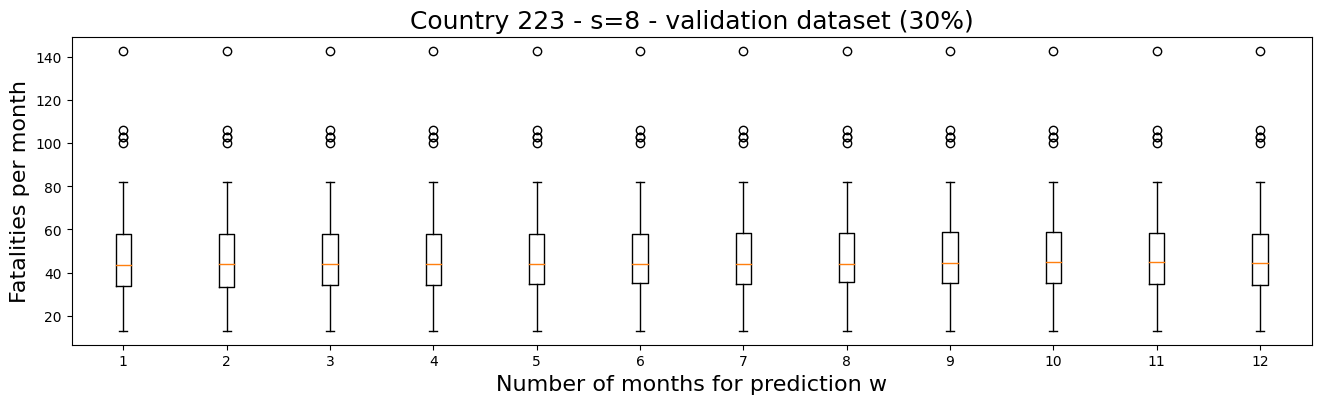

In [166]:
plt.figure(figsize=(16, 4))
for w in range(1,12+1):
    # Erstellen Sie den Boxplot für data
    plt.boxplot(YYdistribution_list[w-1]['Y_train'], positions=[w-1 + 1], labels=[str(w)])

# Optional: Beschriftungen hinzufügen
plt.xlabel('Number of months for prediction w', fontsize=16)
plt.ylabel('Fatalities per month', fontsize=16)
plt.title('Country ' +str(country) + ' - s=' + str(s) + ' - training dataset (70%)', fontsize=18)

# Den Boxplot anzeigen
plt.show()

plt.figure(figsize=(16, 4))
for w in range(1,12+1):
    # Erstellen Sie den Boxplot für data2 neben data
    plt.boxplot(YYdistribution_list[w-1]['Y_valid'], positions=[w - 1 +1], labels=[str(w)])

# Optional: Beschriftungen hinzufügen
plt.xlabel('Number of months for prediction w', fontsize=16)
plt.ylabel('Fatalities per month', fontsize=16)
plt.title('Country ' +str(country) + ' - s=' + str(s) + ' - validation dataset (30%)', fontsize=18)

# Den Boxplot anzeigen
plt.show()

- **Country 13: Few Fatalities at Present, Greater Incidence in the Past**  
  In this context, there are presently few fatalities, but historically, there were higher fatalities over a considerable period. The conflict causing these fatalities may have waned, yet remnants continue to pose a minor threat.

- **Country 60:**

- **Country 121: On-and-Off Conflict, Resuming and Ceasing Periodically**  
  This scenario pertains to conflicts that had ceased, then restarted, and subsequently ceased again.

- **Country 223: Sustained Moderate Fatalities, with a Single Month of Zero Fatalities**  
  Here, the conflict is characterized by consistent moderate fatalities, with the exception of one occurrence out of 334 months when there were no fatalities.

- **Country 220: Erupted Severe Conflict with High Fatalities and Conflict Trap**  
  This category involves conflicts that have erupted, leading to significant fatalities and establishing a conflict trap, characterized by prolonged and sustained violence.

In [159]:
subsample_list = [79, 220, 223]
country_list_original = country_list
country_list = [x for x in country_list if x in subsample_list]

In [160]:
feature_subset = 'all'
w_min = 1
rel_validation_size = 0.3
k=1
k_max = 1
w_max = 6

YYdistribution_list = [{'Y_train':None, 'Y_valid':None } for _ in range(len(country_list))]

s = 8

for i,country in enumerate(country_list):
    ### load and prepare datasets
    feature_data = country_feature_group_list[dataset_index].get_group(country)

    # only FEATURE SUBSET
    feature_data = feature_data.loc[:,feature_subset_dict[feature_subset]]

    ## Drop features with NEAR ZERO VARIANCE (but dont drop 'ged_sb' -> needed for conflict trap detection)
    columns_to_keep = [col for col in feature_data.columns if (col == 'ged_sb') or (feature_data[col].var() >= var_threshold)]
    feature_data = feature_data[columns_to_keep]

    actual_data = country_actual_group_list[dataset_index].get_group(country)

    ## remove months before the CONDFLICT TRAP (regime change)
    # if the average number of fatalities per month in 6 months is above 'mean_fatlities_per_month_threshold' and the fatalities of the starting month are > 0 
    # the conflict trap starts and all obsservations before that month are dropped
    # 76 is the minimal length of the dataframe (refers to the minimal size of the data for all countries -> country_id 246 len = 76) 
    feature_data = drop_before_conflict_trap(feature_data, mean_fatlities_per_month_threshold, 6, 76)



    month_liste = feature_data.index.get_level_values('month_id').tolist()

    month_list_train, month_list_valid, month_list_test, w = month_lists_TrainValidTest_RollWindow(w_min, w_max, rel_validation_size, k, k_max, month_liste)

    ## training dataset------
    X_train, Y_train = TrainValid_ArrayXY_split(w, month_list_train, feature_data, s)

    ## validation dataset--------
    X_validate, Y_validate = TrainValid_ArrayXY_split(w, month_list_valid, feature_data, s)

    ## test dataset-------
    X_test, Y_test = Test_ArrayXY_split(month_list_test, feature_data, actual_data, s)

    YYdistribution_list[i]['Y_train'] = Y_train
    YYdistribution_list[i]['Y_valid'] = Y_validate

Wmax = 6 w = 6
rolling windows train: 119
rolling windows validate: 40
Wmax = 6 w = 6
rolling windows train: 56
rolling windows validate: 12
Wmax = 6 w = 6
rolling windows train: 236
rolling windows validate: 90


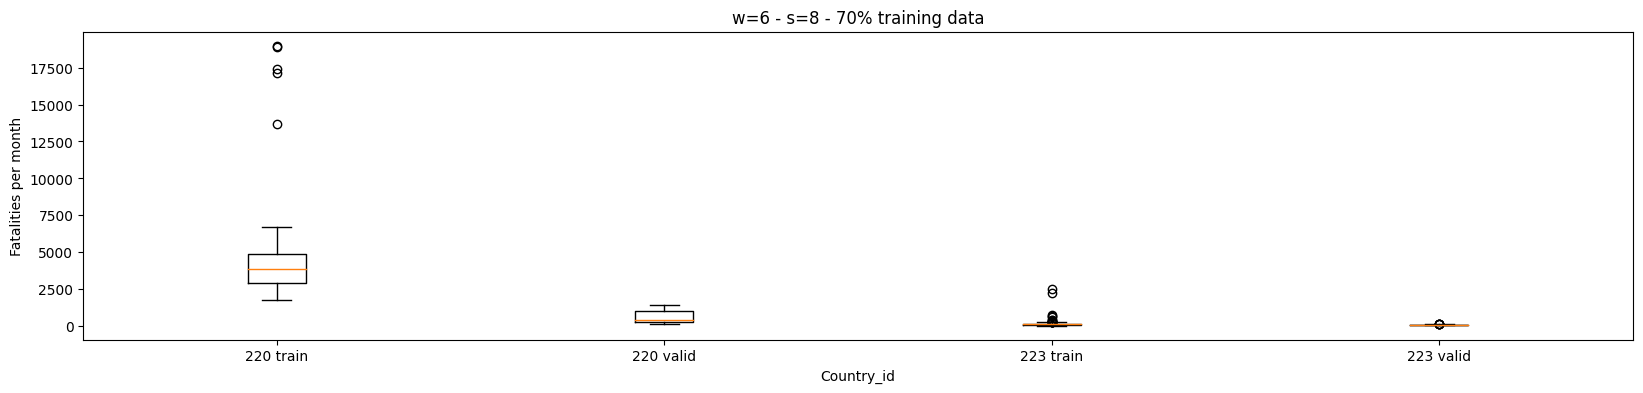

In [156]:
plt.figure(figsize=(20, 4))
counter = 0
for i,country in enumerate(country_list):
    if i % 2 == 0:
        # Erstellen Sie den Boxplot für data
        plt.boxplot(YYdistribution_list[i]['Y_train'], positions=[i + counter + 1], labels=[str(country) + ' train'])
        # Erstellen Sie den Boxplot für data
        plt.boxplot(YYdistribution_list[i]['Y_valid'], positions=[i + counter + 2], labels=[str(country) + ' valid'])

        counter += 1
    elif i % 2 == 1:
        # Erstellen Sie den Boxplot für data
        plt.boxplot(YYdistribution_list[i]['Y_train'], positions=[i + counter + 1], labels=[str(country) + ' train'])
        # Erstellen Sie den Boxplot für data
        plt.boxplot(YYdistribution_list[i]['Y_valid'], positions=[i + counter + 2], labels=[str(country) + ' valid'])

        counter += 1

# Optional: Beschriftungen hinzufügen
plt.xlabel('Country_id')
plt.ylabel('Fatalities per month')
#plt.yscale('log', base=2)
plt.title('w=' +str(w_max) + ' - s=' + str(s) + ' - 70% training data')

# Den Boxplot anzeigen
plt.show()

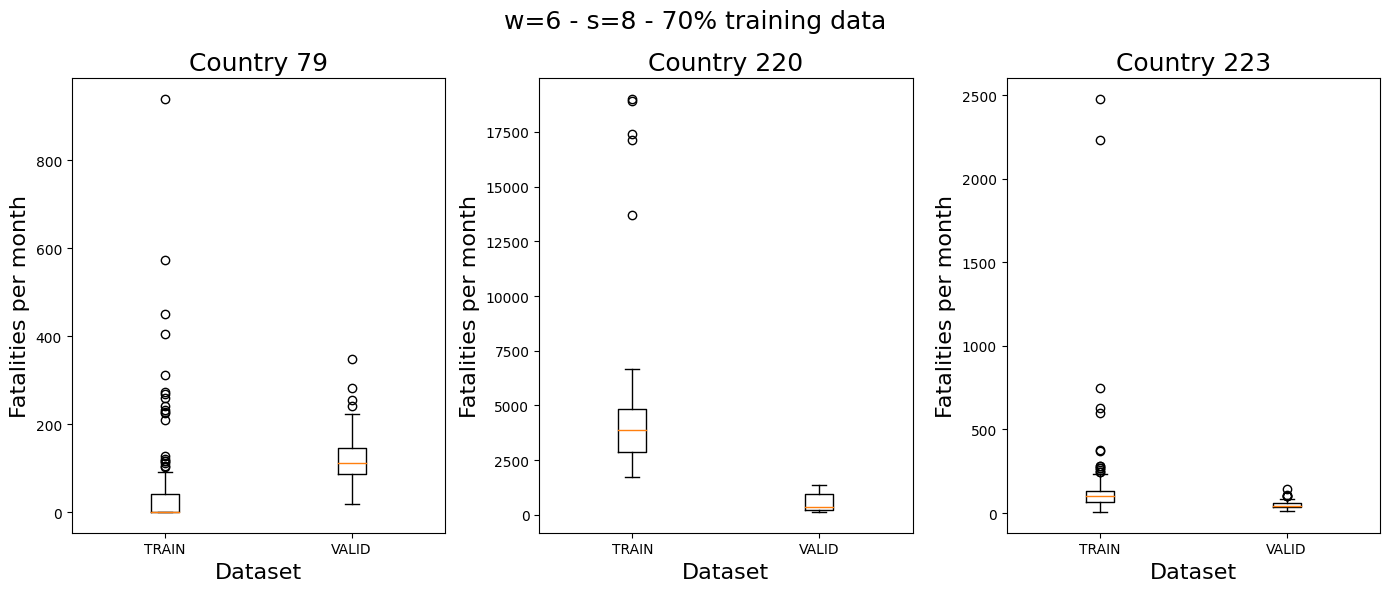

In [161]:
import matplotlib.pyplot as plt

# Anzahl der Länder
num_countries = len(country_list)

# Anzahl der Zeilen und Spalten im Raster
num_cols = num_countries

# Erstellen Sie das Raster von Subplots
fig, axs = plt.subplots(1, num_cols, figsize=(14, 6))

# Schleife durch jedes Land
for i, country in enumerate(country_list):
    # Daten für "train" und "valid" des aktuellen Landes
    Y_train = YYdistribution_list[i]['Y_train']
    Y_valid = YYdistribution_list[i]['Y_valid']

    # Plotten Sie "train" in der linken Spalte des aktuellen Subplots
    axs[i].boxplot(YYdistribution_list[i]['Y_train'], positions=[1], labels=['TRAIN'])
    axs[i].boxplot(YYdistribution_list[i]['Y_valid'], positions=[2], labels=['VALID'])
    axs[i].set_title('Country ' + str(country), fontsize=18)  # Schriftgröße für den Titel erhöhen
    axs[i].set_xlabel('Dataset', fontsize=16)  # Schriftgröße für die Achsenbeschriftung erhöhen
    axs[i].set_ylabel('Fatalities per month', fontsize=16)  # Schriftgröße für die Achsenbeschriftung erhöhen

plt.suptitle(f'w={w_max} - s={s} - 70% training data', fontsize=18)  # Schriftgröße für den Haupttitel erhöhen

# Abstand zwischen den Subplots festlegen
plt.tight_layout()

# Den Plot anzeigen
plt.show()


# Einschub: Analyse der unterschiedlichen Ländern mit Conflict trap

### Countries separated by fatalities

In [15]:
zero_fatalities_country_list = []
countries_with_high_percentage_list = []
someNonzero_fatalities_country_list = []

for country_id in country_list:
    feature_data = country_feature_group_list[0].get_group(country_id)

    # Berechnen des Prozentsatzes der Werte größer als 0 in der Spalte 'ged_sb'
    positive_percentage = (feature_data['ged_sb'] > 0).mean() * 100

    if (feature_data['ged_sb'] == 0).all():
        zero_fatalities_country_list.append(country_id)
    elif positive_percentage >= 60:
        countries_with_high_percentage_list.append(country_id)
    else:
        someNonzero_fatalities_country_list.append(country_id)

print('Countries with >= 60% months with fatalities: ' + str(countries_with_high_percentage_list))

Countries with >= 60% months with fatalities: [28, 60, 65, 67, 96, 121, 133, 136, 145, 149, 218, 223, 245, 246]


In [16]:
len(someNonzero_fatalities_country_list)/191

0.418848167539267

### Countries with conflict trap and the removed months

In [17]:
country_list_nonzerofatalities = countries_with_high_percentage_list + someNonzero_fatalities_country_list
country_list_nonzerofatalities.sort()
country_list_nonzerofatalities

for country_id in country_list_nonzerofatalities:
    feature_data = country_feature_group_list[0].get_group(country_id)

    trap_data = drop_before_conflict_trap(feature_data, 10, 6, 76)

    if len(trap_data) < len(feature_data):
        print('trap country_id: ' + str(country_id) + ' removed months: ' + str(len(feature_data)-len(trap_data)) + ' len trap_data = ' + str(len(trap_data)))

trap country_id: 4 removed months: 25 len trap_data = 309
trap country_id: 17 removed months: 48 len trap_data = 286
trap country_id: 24 removed months: 21 len trap_data = 313
trap country_id: 31 removed months: 1 len trap_data = 333
trap country_id: 41 removed months: 152 len trap_data = 182
trap country_id: 48 removed months: 128 len trap_data = 206
trap country_id: 49 removed months: 101 len trap_data = 233
trap country_id: 50 removed months: 5 len trap_data = 329
trap country_id: 52 removed months: 32 len trap_data = 302
trap country_id: 53 removed months: 14 len trap_data = 320
trap country_id: 55 removed months: 4 len trap_data = 330
trap country_id: 56 removed months: 67 len trap_data = 227
trap country_id: 57 removed months: 5 len trap_data = 289
trap country_id: 65 removed months: 21 len trap_data = 290
trap country_id: 67 removed months: 22 len trap_data = 312
trap country_id: 69 removed months: 258 len trap_data = 76
trap country_id: 70 removed months: 136 len trap_data = 19

In [18]:
max_fatalities = 0
country_id_max = 0

for country_id in country_list_nonzerofatalities:
    feature_data = country_feature_group_list[0].get_group(country_id)

    if feature_data.loc[:,'ged_sb'].max() > max_fatalities:
        max_fatalities = feature_data.loc[:,'ged_sb'].max()
        country_id_max = country_id

print('Country: ' + str(country_id_max) + ' fatalities = ' + str(max_fatalities))

Country: 57 fatalities = 48183.0


### View dataset of country with id

In [89]:
pd.options.display.max_rows = 1000


""" 
    - 1 keine todesfälle
    - 57 extrem selten todesfälle aber ein paar sind extrem hoch (maximum aller länder -> in einem Monat: 48183.0)
    - 235 krieg der aufgehört hat
    - 13 aktuell wenige todesfälle vor langer zeit mehr (krieg der aufgehört hat aber noch immer etwas schwelt)
    - 121 krieg der aufgehört hat aber wieder angefangen hat und dann wieder aufgehört hat
    - 223 konstant mittlere todesfälle, nur 1 von 334 monaten 0 
    - 220 ausgebrochener krieg mit sehr hohen todeszahlen und conflict trap
    """

data = country_feature_group_list[0].get_group(60)

#data = drop_before_conflict_trap(data, 30, 6, 76)

#data#.loc[:,'ged_sb'] == 0
data

,,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,ind_efficiency_t48,irr_agr_efficiency_t48,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5
month_id,country_id,,,,,,,,,,,,,,,,,,,,,
121,60,60.0,0.0,23.0,0.0,0.0,0.0,110.0,17442590.0,50.0,0.0,...,39.981087,0.203303,35.989558,1.610023,58.112360,2212.478100,5648.104604,1.156250,1.156250,0.187500
122,60,0.0,0.0,0.0,0.0,0.0,0.0,110.0,17442590.0,60.0,50.0,...,39.981087,0.203303,35.989558,1.610023,58.112360,2212.478100,5648.104604,1.151802,1.123334,0.182162
123,60,0.0,0.0,0.0,0.0,0.0,0.0,110.0,17442590.0,0.0,60.0,...,39.981087,0.203303,35.989558,1.610023,58.112360,2212.478100,5648.104604,1.147480,1.091355,0.176976
124,60,0.0,0.0,0.0,0.0,0.0,0.0,110.0,17442590.0,0.0,0.0,...,39.981087,0.203303,35.989558,1.610023,58.112360,2212.478100,5648.104604,1.143282,1.143282,0.171938
125,60,0.0,0.0,0.0,0.0,0.0,0.0,110.0,17442590.0,0.0,0.0,...,39.981087,0.203303,35.989558,1.610023,58.112360,2212.478100,5648.104604,1.139203,1.139203,0.167044
126,60,34.0,0.0,0.0,0.0,0.0,0.0,144.0,17442590.0,0.0,0.0,...,39.981087,0.203303,35.989558,1.610023,58.112360,2212.478100,5648.104604,1.135240,1.135240,0.162288
127,60,0.0,0.0,0.0,0.0,0.0,0.0,144.0,17442590.0,34.0,0.0,...,39.981087,0.203303,35.989558,1.610023,58.112360,2212.478100,5648.104604,2.105112,1.131390,0.157668
128,60,0.0,0.0,0.0,0.0,0.0,0.0,144.0,17442590.0,0.0,34.0,...,39.981087,0.203303,35.989558,1.610023,58.112360,2212.478100,5648.104604,2.102120,1.099182,0.153180
129,60,0.0,0.0,0.0,0.0,0.0,0.0,144.0,17442590.0,0.0,0.0,...,39.981087,0.203303,35.989558,1.610023,58.112360,2212.478100,5648.104604,3.045941,1.067890,0.148819


# To Do

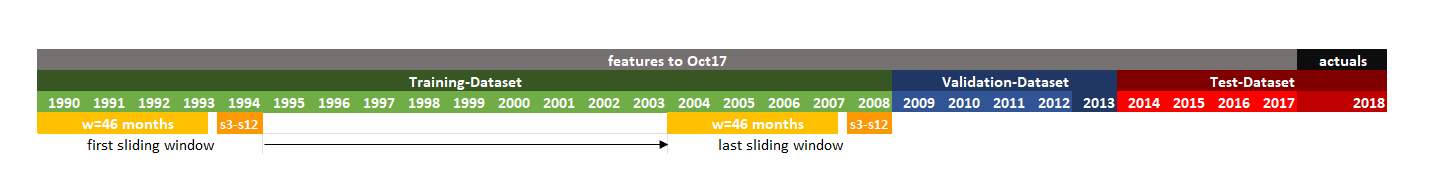

### Estimation and Prediction

In [21]:
## neural net hyperparams
batchSize = 1
epochSize = 100
learningRate = 0.1

# Define inputs with predefined shape
input_shape = (len(X_train[0]),)
inputs = Input(shape=input_shape)
#print(inputs.shape)

# Print model summary
#model.summary()


# Create an instance of the FeedForwardNN model
model = FeedForwardNN(input_shape=inputs.shape, name='FFwdNN_s3')

# Compile the model
model.compile(optimizer=Adam(learning_rate=learningRate), loss=CRPSLoss())

history = model.fit(X_train, Y_train, 
                    batch_size=batchSize, epochs=epochSize,
                    validation_data=(X_validate, Y_validate),
                    callbacks=[early_stopping], #early_stopping
                    verbose=1, shuffle=False)


print('')
print('')

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=batchSize)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate prediction")
prediction = model.predict(X_test)
print("predictions shape:", prediction.shape)
empirical_distribution = np.round(np.sort(prediction[0])).astype(int)


Epoch 1/100
45/45 [==============================] - 27s 116ms/step - loss: 3207.0312 - val_loss: 182.5833
Epoch 2/100
45/45 [==============================] - 0s 8ms/step - loss: 2804.5669 - val_loss: 477.2232
Epoch 3/100
45/45 [==============================] - 0s 9ms/step - loss: 2459.6475 - val_loss: 560.1001
Epoch 4/100
45/45 [==============================] - 0s 8ms/step - loss: 2431.1528 - val_loss: 487.8097


Evaluate on test data
1/1 [==============================] - 0s 48ms/step - loss: 142.5866
Generate prediction
1/1 [==============================] - 0s 155ms/step
predictions shape: (1, 200)


In [22]:
print('Parameters data prep: ' + ' \\'+'\\' + 'wMax='+ str(w_max) + ' validationSize='+str(rel_validation_size) + ' conflictTrapThresh=' + str(mean_fatlities_per_month_threshold) + ' features='+feature_subset+ ' \\'+'\\')
print('Parameters NN: ' + ' \\'+'\\' + 'earlyStoppingPatience=' + str(patience) + ' learningRate='+str(learningRate)+' numberHiddenLayers=2 numberNeurons=neurons_hidden_layer validationSize='+str(rel_validation_size))

Parameters data prep:  \\wMax=12 validationSize=0.3 conflictTrapThresh=5 features=all \\
Parameters NN:  \\earlyStoppingPatience=3 learningRate=0.1 numberHiddenLayers=2 numberNeurons=neurons_hidden_layer validationSize=0.3


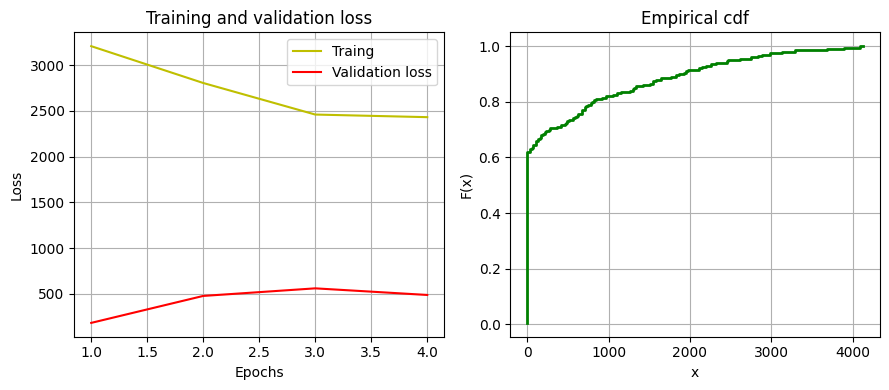

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def empirical_cdf(data):
    n = len(data)
    ecdf_values = np.arange(1, n + 1) / n
    return ecdf_values

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Berechne die empirische CDF
ecdf = empirical_cdf(empirical_distribution)

# Erstelle eine Figur mit 1 Zeile und 2 Spalten für die beiden Plots nebeneinander und kleiner
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].plot(epochs, loss, 'y', label='Traing')
axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
axes[0].set_title('Training and validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plotte die empirische CDF im zweiten Subplot
axes[1].step(empirical_distribution, ecdf, label='Empirical Density Function', color='green', linewidth=2)
axes[1].set_xlabel('x')
axes[1].set_ylabel('F(x)')
axes[1].set_title('Empirical cdf')
axes[1].grid(True)

plt.tight_layout()  # Optimiere den Abstand zwischen den Subplots
plt.show()


In [24]:
y_true = Y_test[0][0]
crps_check = pscore(empirical_distribution,y_true).compute()[0]
print('CRPS = ' + str(crps_check))

CRPS = 142.58117500000003


In [25]:
empirical_distribution

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   36,   40,   62,   71,   78,  103,  109,  114,  137,
        163,  170,  172,  196,  214,  229,  267,  275,  369,  416,  470,
        477,  486,  508,  569,  592,  615,  628,  6

In [26]:
""" 
    die conflict trap zu beachten hilft extrem

    
    
    """

' größere emp. distribution  hat kaum einen Einfluss, wird nur genauer abgebildet\n\n    mehr neuronen in den Hidden layers führen zu einem heavier tail (mehr extremwerte) -> schlechtere performance\n\n    zwei hidden layer neigen bei zu vielen neuronen zu overfitting, allerdings liefern zwei hidden layer mit weniger\n    neuronen bessere ergebnisse als ein hidden layer mit gleich vielen neuronen wie die beiden hidden layer zusammen -> können\n    komplexere zusammenhänge erkennen\n\n    die conflict trap zu beachten hilft extrem\n\n    \n    \n    '

## Overfitting, wenn
- Niedriger Trainingsverlust, hoher Validierungsverlust: Ein deutlich niedrigerer Trainingsverlust im Vergleich zum Validierungsverlust deutet auf Overfitting hin. Das Modell lernt die Trainingsdaten sehr gut, kann aber die Validierungsdaten nicht gut generalisieren.

- Schnelle Konvergenz des Trainingsverlusts: Der Trainingsverlust kann sehr schnell abnehmen und sich dennoch auf einem niedrigen Niveau stabilisieren. Dies kann darauf hindeuten, dass das Modell die Trainingsdaten auswendig gelernt hat.

- Große Differenz zwischen Trainings- und Validierungsverlust: Overfitting zeigt sich in einer wachsenden Kluft zwischen Trainings- und Validierungsverlust. Während der Trainingsverlust weiter abnimmt, steigt der Validierungsverlust an.

- Hohe Modellleistung auf Trainingsdaten: Das Modell erzielt eine hohe Genauigkeit oder R²-Wert auf den Trainingsdaten, jedoch eine niedrigere Leistung auf den Validierungs- oder Testdaten.

- Sichtbares Overfitting in Lernkurven: Die Lernkurven können eine Sättigung des Trainingsverlusts zeigen, gefolgt von einem Anstieg des Validierungsverlusts, wenn das Modell übertrainiert wird.

- Komplexe Modellarchitektur: Overfitting kann auftreten, wenn das Modell zu komplex ist und eine hohe Anzahl von Parametern hat, die es ihm ermöglichen, die Trainingsdaten genau zu modellieren.
